In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import datetime
from scipy.stats import linregress
import json
import pprint
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import API key

from api_keys import api_key


In [3]:
# read in csv
oscar_data= pd.read_csv("Resources/oscar_data.csv")

In [4]:
all_nominees = oscar_data[["Year", "Best Picture", "Nominee 1", "Nominee 2", "Nominee 3", "Nominee 4"]]

#Can we do all nominees in every category just for one year as well?

In [5]:
base_url = "https://api.themoviedb.org/3/"

#Enter year

year = "2018"

startdate = f"{year}-01-01"
enddate = f"{year}-12-31"

all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}').json()
total_pages = json.dumps(all_movies_response["total_pages"], indent=4, sort_keys=True)

In [6]:
responseid = {'Title' : [],'ID' : [], 'Vote Average' : [], 'Release Date' : []}

#Request from API for each month
for i in range(1,int(total_pages)//10):

#EDIT DATES FOR DIFFERENT YEARS
    all_movies_response = requests.get(f'{base_url}/discover/movie?include_adult=false&include_video=false&primary_release_date.gte={startdate}&primary_release_date.lte={enddate}&with_original_language=en&sort_by=vote_count.desc&api_key={api_key}&page={i}').json()
    total_pages = json.dumps(all_movies_response["total_pages"], indent=4, sort_keys=True)

    #puts all results into a dictionary
    for j in range(len(all_movies_response["results"])):
        responseid['Title'].append(all_movies_response["results"][j]["title"])
        responseid['ID'].append(all_movies_response["results"][j]["id"])
        responseid['Vote Average'].append(all_movies_response["results"][j]["vote_average"])
        responseid['Release Date'].append(all_movies_response["results"][j]["release_date"])

In [7]:
#dictionary to dataframe, sorted and prepped for use

input_format = '%Y-%m-%d'
moviedata = pd.DataFrame(responseid)
# input string
moviedata['Release Date'] = pd.to_datetime(moviedata['Release Date'], utc=True)

moviedata['Release Date UNIX'] = moviedata['Release Date'].astype(np.int64)

moviedata = moviedata.sort_values("Release Date")
#moviedata['Release Date UNIX'] = (moviedata['Release Date'] - datetime(1970,1,1)).total_seconds()
moviedata['Day'] = moviedata['Release Date'].dt.day
moviedata['Month'] = moviedata['Release Date'].dt.strftime('%b')
moviedata['Month Number'] = moviedata['Release Date'].dt.month
moviedata['Year'] = moviedata['Release Date'].dt.year
moviedata = moviedata.reset_index(drop=True)

moviedata["Nominated"] = ""
moviedata

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated
0,House of Deadly Secrets,523443,4.700,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,
1,Bees Make Honey,476634,4.706,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,
2,Grandpa's Great Escape,495737,5.900,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,
3,Mad World,520788,5.300,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018,
4,Toy Gun,514782,4.083,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018,
...,...,...,...,...,...,...,...,...,...,...
1375,"New Year, New You",567220,4.913,2018-12-28 00:00:00+00:00,1545955200000000000,28,Dec,12,2018,
1376,Stan & Ollie,394741,6.974,2018-12-28 00:00:00+00:00,1545955200000000000,28,Dec,12,2018,
1377,A Midnight Kiss,550036,5.897,2018-12-29 00:00:00+00:00,1546041600000000000,29,Dec,12,2018,
1378,The Wrong Patient,571768,6.800,2018-12-30 00:00:00+00:00,1546128000000000000,30,Dec,12,2018,


In [8]:
titles = moviedata['Title'].to_list()
noms = []


for movie in titles:
    mask = oscar_data[oscar_data.apply(lambda row: row.astype(str).str.contains(str(movie), case=False).any(), axis=1)]
    if mask.empty:
        noms.append("No")
        
    else:
        if mask['Year'].values[0] == year:
            noms.append("Yes")
        else:
            noms.append("No")

moviedata['Nominated'] = noms

In [9]:
nominatedmovies = moviedata.loc[moviedata['Nominated'] == "Yes"]

In [10]:
season = []

for row in nominatedmovies['Month']:
    if row in ("Nov", "Dec"):
        season.append("Yes")
    else:
        season.append("No")

nominatedmovies['Oscar Season'] = season

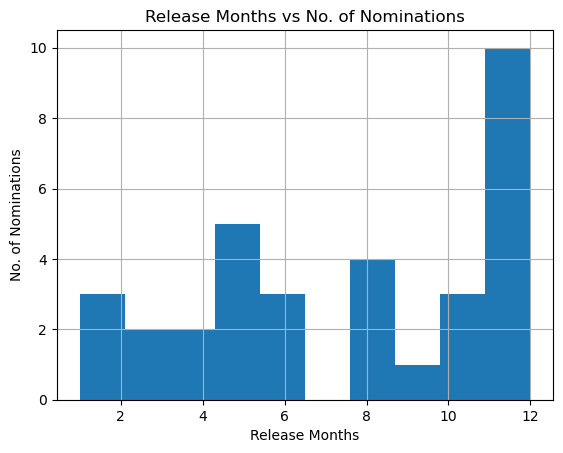

In [16]:
# Histogram - Release Month vs Nominations
nominatedmovies.hist(column='Month Number')
plt.title('Release Months vs No. of Nominations')
plt.xlabel('Release Months')
plt.ylabel('No. of Nominations')

plt.savefig('resources/output/Histogram.png')

# Display the histogram
plt.show()

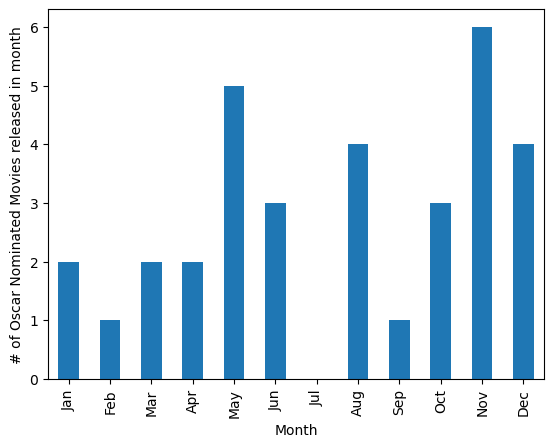

In [17]:
#Basic Bar Chart below

labels = moviedata["Month"].unique()
y_axis = nominatedmovies["Month"].value_counts()
histodf = pd.DataFrame({'# of Oscar Nominated Movies released in month': y_axis}, index=labels)
ax = histodf['# of Oscar Nominated Movies released in month'].plot(kind="bar")
plt.xlabel("Month")
plt.ylabel("# of Oscar Nominated Movies released in month")
plt.savefig('resources/output/Oscars released by month.png')
plt.show()

In [18]:
#Line plot – two lines, year against no. of nominations, line 1 for October – December, line 2 for January – September


In [19]:
moviedata.head()

,Title,ID,Vote Average,Release Date,Release Date UNIX,Day,Month,Month Number,Year,Nominated
0,Bees Make Honey,476634,4.706,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,No
1,House of Deadly Secrets,523443,4.700,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,No
2,Grandpa's Great Escape,495737,5.900,2018-01-01 00:00:00+00:00,1514764800000000000,1,Jan,1,2018,No
3,Mad World,520788,5.300,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018,No
4,Toy Gun,514782,4.083,2018-01-02 00:00:00+00:00,1514851200000000000,2,Jan,1,2018,No


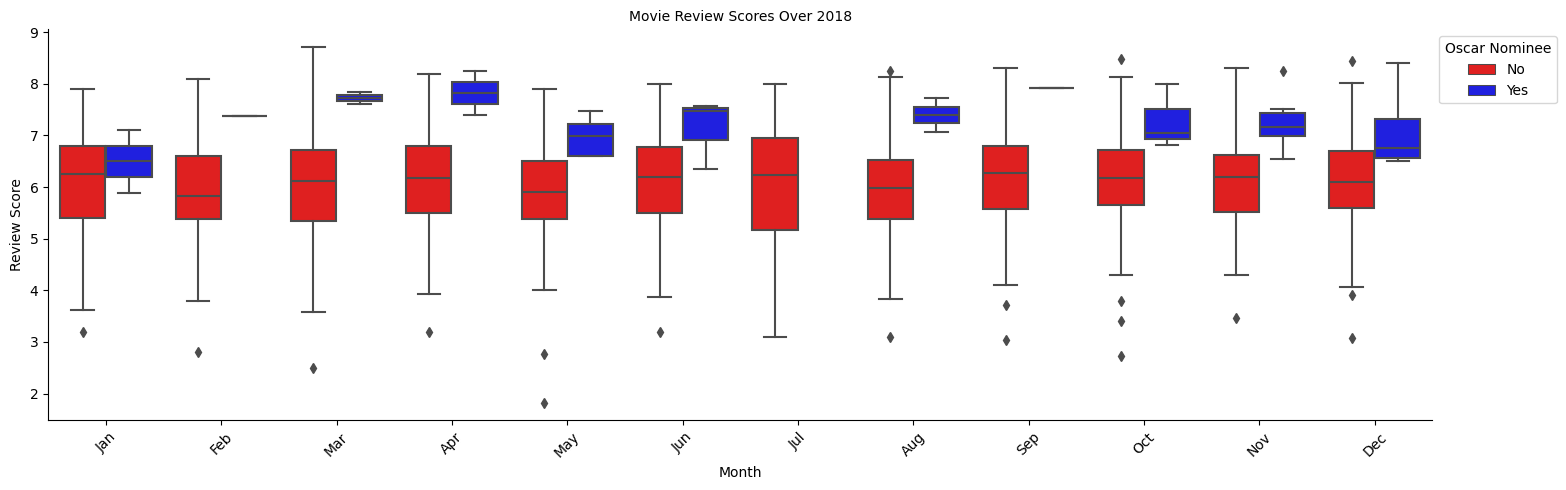

In [20]:

import matplotlib.pyplot as plt

# Assuming your data is named 'moviedata' and contains columns 'Year', 'Month', 'Vote Average', and 'Nominated'

# Create the FacetGrid with year as the column variable
g = sns.FacetGrid(moviedata, col='Year', col_wrap=3, aspect=3, height=5)

# Map the boxplot onto the FacetGrid with custom palette
g.map(sns.boxplot, 'Month', 'Vote Average', 'Nominated', palette={'Yes': 'blue', 'No': 'red'})

# Add legend outside the plot area
plt.legend(title='Oscar Nominee', loc='upper left', bbox_to_anchor=(1, 1))

# Set titles, labels, and rotation
g.set_titles('Movie Review Scores Over {col_name}')
g.set_xlabels('Month')
g.set_ylabels('Review Score')
plt.xticks(rotation=45)

plt.savefig('resources/output/movie_review_scores.png')

plt.tight_layout()
plt.show()


In [21]:
def linregplot(i,x,y,j,k):
    lr_slope, lr_int, lr_r, lr_p, lr_std_err = linregress(i[x],i[y])
    lr_fit = lr_slope * i[x] + lr_int
    title = str(f"{j} vs. {k}")
    plt.scatter(i[x],i[y], alpha= 0.8, edgecolors= 'black')
    plt.plot(i[x],lr_fit, 'r', label = 'y = {:.2f} + {:.2f}*x'.format(lr_slope, lr_int))
    plt.legend(loc = 'best')
    plt.xticks(rotation=0)
    plt.xlabel(j)
    plt.ylabel(k)
    plt.title(title)
    print(f"The r-value is: {lr_r}")
    plt.savefig('resources/output/scatterplot.png')
    plt.show()

The r-value is: 0.03996319289905455


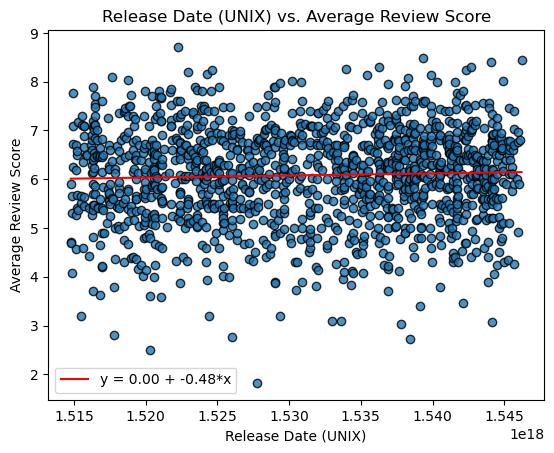

In [22]:
#Scatter Plot with Linreg

linregplot(moviedata, 'Release Date UNIX', 'Vote Average', 'Release Date (UNIX)', 'Average Review Score')

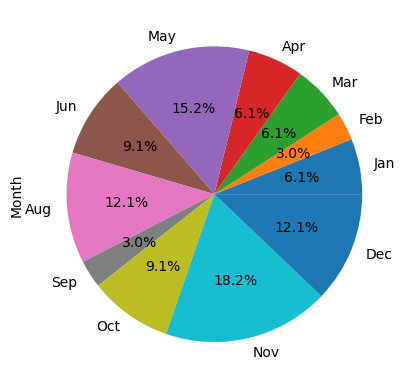

In [23]:
#Month Pie Chart

data_grouped_month = nominatedmovies.groupby(["Month"])
labels_month = nominatedmovies["Month"].unique()
bymonth = data_grouped_month["Month"].value_counts()
df_bymonth = pd.DataFrame({'Month': bymonth}, index=labels_month)
plot_bymonth = df_bymonth['Month'].plot(kind="pie", autopct='%.1f%%')

# Save the plot
plt.savefig('resources/output/movie_distribution_by_month.png')

plt.show()



Oscar Season is defined as November/December, 16.6% of the year


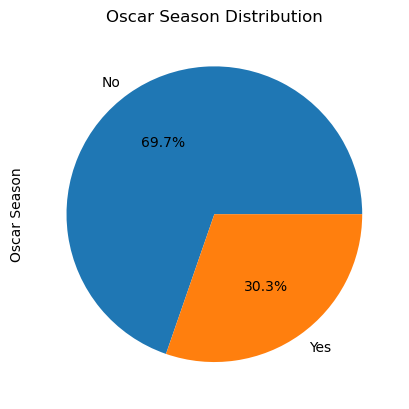

In [26]:
#Oscar Season Pie Chart

print("Oscar Season is defined as November/December, 16.6% of the year")

data_grouped_month = nominatedmovies.groupby(["Oscar Season"])
labels_month = nominatedmovies["Oscar Season"].unique()
bymonth = data_grouped_month["Oscar Season"].value_counts()
df_bymonth = pd.DataFrame({'Oscar Season': bymonth}, index=labels_month)
plot_bymonth = df_bymonth['Oscar Season'].plot(kind="pie", autopct='%.1f%%')

# Set the title
plt.title('Oscar Season Distribution')

# Save the plot
plt.savefig('resources/output/oscar_season_distribution.png')

plt.show()


In [11]:
## Hypothesis Testing

import scipy.stats as stats

# Subset the data into two groups: nominated and not nominated movies
nominated_movies = moviedata[moviedata['Nominated'] == 'Yes']['Vote Average']
not_nominated_movies = moviedata[moviedata['Nominated'] == 'No']['Vote Average']

# Define the null hypothesis: There is no significant difference in the average vote average between nominated and not nominated movies
# H0: μ1 = μ2 (where μ1 is the mean vote average of nominated movies and μ2 is the mean vote average of not nominated movies)
# Define the alternative hypothesis: There is a significant difference in the average vote average between nominated and not nominated movies
# H1: μ1 ≠ μ2
# This is a two-tailed test

# Perform a t-test
t_statistic, p_value = stats.ttest_ind(nominated_movies, not_nominated_movies, equal_var=False)

# Set the significance level
alpha = 0.05

# Print the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Compare p-value to significance level
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in the average vote average between nominated and not nominated movies.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the average vote average between nominated and not nominated movies.")


T-Statistic: 11.30597446458255
P-Value: 1.845020669018569e-13
Reject the null hypothesis. There is a significant difference in the average vote average between nominated and not nominated movies.
